All of the necessary imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt #For plotting results; optional

## Import Landlab components
#Pit filling; optional
from landlab.components import DepressionFinderAndRouter
#Flow routing
from landlab.components import PriorityFloodFlowRouter
#For Groundwater
from landlab.components import GroundwaterDupuitPercolator

#SPACE model
from landlab.components import Space #SPACE model
from landlab.components import FastscapeEroder 

from landlab.components import SinkFillerBarnes

## Import Landlab utilities
from landlab import RasterModelGrid #Grid utility
from landlab import imshow_grid #For plotting results; optional
from landlab.io import read_esri_ascii
from landlab.io import read_asc_header 
%matplotlib inline

Retrieving the DEM files and importing into progam as a rasterModelGrid

[403157]
426258
[]


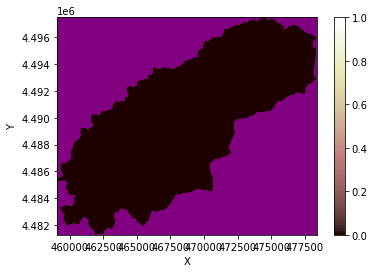

In [63]:
#Set directory paths to retrieve the asc file
path_project = r"C:/Users/gsbir/Documents/EES_393/" # add the path to the asc file    #this should access my H drive
filename_dem = "saucon_txt.txt" #the name of the asc file
path_dem = path_project + filename_dem

#now read the header of the asc file (where there is ncols nrows cell size and nodata value)
dem_header = read_asc_header(open(path_dem, 'r'))
#use the above to see your grid dimensions, what the no data value is etc...

#generate new grid and add DEM values into 'topographic__elevation'
(mg, z) = read_esri_ascii(path_dem, name= 'topographic__elevation', halo = 1)


#set the watershed boundary condition and plot the
outlet_id = mg.set_watershed_boundary_condition(z, nodata_value = -9999, return_outlet_id=True)
#This should find your outlet node automatically and
print(outlet_id)

print(mg.number_of_nodes)
#print(mg.at_node.keys()) #Shows the node attributes
#print(mg.corners_at_left_edge)

#this line can look at the boundary status of the nodes to see where the outlet is
imshow_grid(mg, mg.status_at_node, color_for_closed = 'purple')

# %% Hydrologically condition DEM (fill sinks)
sfb = SinkFillerBarnes(mg, surface=z, method='D8', fill_flat=False)
sfb.run_one_step()#This is important to ensure that your future flow routing will work properly.


Adding new nodes to the rasterModelGrid: soil__depth, bedrock__elevation 

In [64]:
#Set grid parameters
num_rows = 712
num_columns = 595
node_next_to_outlet = num_columns + 1
node_spacing = 27.097698258644

#Set model timestep
timestep = 1 #years

#Set model run time
run_time = 1 #years
uplift_rate = .001 # m/year
uplift_per_timestep = uplift_rate * timestep


#Add field 'soil__depth' to the grid
mg.add_zeros('node', 'soil__depth')

#Set 2 m of initial soil depth at core nodes
mg.at_node['soil__depth'][mg.core_nodes] = 2.0 #meters 

#Add field 'bedrock__elevation' to the grid
mg.add_zeros('bedrock__elevation', at='node')

#Sum 'soil__depth' and 'bedrock__elevation'
#to yield 'topographic elevation'
mg.at_node['bedrock__elevation'][:] = mg.at_node['topographic__elevation'] - mg.at_node['soil__depth']
#mg.at_node['topographic__elevation'][:] += mg.at_node['soil__depth']


Setting Boundary Conditions of the Grid

In [65]:
#Close all model boundary edges
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,
                                       left_is_closed=True,
                                       right_is_closed=True,
                                       top_is_closed=True)


Instantiating the FlowRouter and the DEpressionFinder and Router and Space model

In [66]:
#Instantiate flow Router- Using the PriorityFLoorFLowRouter as it is significantly faster
fr = PriorityFloodFlowRouter(mg,surface='topographic__elevation', flow_metric='D8', runoff_rate=None, update_flow_depressions=True, depression_handler='fill', exponent=1, epsilon=False, accumulate_flow=True, accumulate_flow_hill=False, separate_hill_flow=False, update_hill_depressions=False, update_hill_flow_instantaneous=False, hill_flow_metric='D8', hill_exponent=1, suppress_out=False)

#Instantiate the depressionfinder and router
df = DepressionFinderAndRouter(mg)

#Instantiate SPACE model with chosen parameters    , method='simple_stream_power'
sp = Space(mg, K_sed=0.01, K_br=0.001, F_f=0., phi=0., H_star=1., v_s=5.0, m_sp=0.5, n_sp=1.0, sp_crit_sed=0, sp_crit_br=0)

Run the Model 

In [67]:
#Set elapsed time to zero
elapsed_time = 0 #years

#Set timestep count to zero
count = 0

#Array to save sediment flux values
#sed_flux = np.zeros(int(run_time // timestep))
sed_flux = [0] * (run_time)                                 ###added this instead of the previous line
while elapsed_time < run_time: #time units of years
    mg.at_node['bedrock__elevation'] += uplift_per_timestep 
    mg.at_node['topographic__elevation'] = mg.at_node['bedrock__elevation'] + mg.at_node['soil__depth']
    
    #df.map_depressions()
    #Run the flow router
    fr.run_one_step()
    
    #Run the depression finder and router; optional
    
    #Get list of nodes in depressions; only
    #used if using DepressionFinderAndRouter
    flooded = np.where(df.flood_status==3)[0]
    sp.run_one_step(dt = timestep) #had to delete flooded_nodes=flooded

    #Save sediment flux value to array
    sed_flux[count] = mg.at_node['sediment__flux'][node_next_to_outlet]
    
    #Add to value of elapsed time
    elapsed_time += timestep
    
    print(count)
    #Increase timestep count
    count += 1

0


Create the Sediment Flux Figure

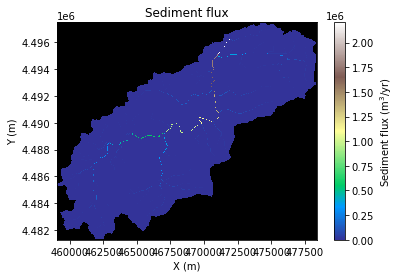

In [68]:
#Instantiate figure
figsed = plt.figure()

#Instantiate subplot
plot = plt.subplot()

#Show sediment flux map
imshow_grid(mg, 'sediment__flux', plot_name='Sediment flux', var_name = 'Sediment flux', var_units=r'm$^3$/yr', grid_units=('m', 'm'), cmap='terrain')

Create the Topographic Elevation Figure

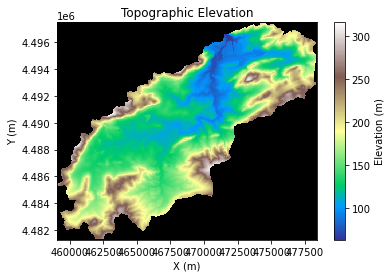

In [69]:
#Instantiate figure
figelev = plt.figure()

#Instantiate subplot
plot = plt.subplot()

#Show sediment flux map
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)

Create the Soil Depth Figure

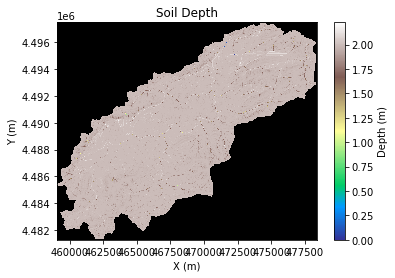

In [70]:
#Instantiate figure
fig = plt.figure()

#Instantiate subplot
plot = plt.subplot()

#Show sediment flux map
imshow_grid(mg, 'soil__depth', plot_name='Soil Depth', var_name = 'Depth', var_units=r'm', grid_units=('m', 'm'), cmap='terrain')

Create the Bedrock Elevation Figure

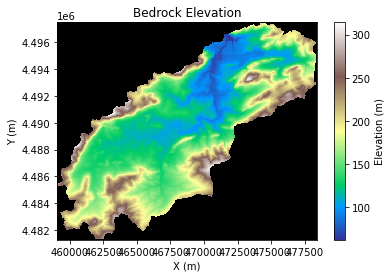

In [71]:
#Instantiate figure
fig = plt.figure()

#Instantiate subplot
plot = plt.subplot()

#Show sediment flux map
imshow_grid(mg, 'bedrock__elevation', plot_name='Bedrock Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain')

Create the Sedimentograph

Text(0, 0.5, 'Sediment flux [m$^3$/yr]')

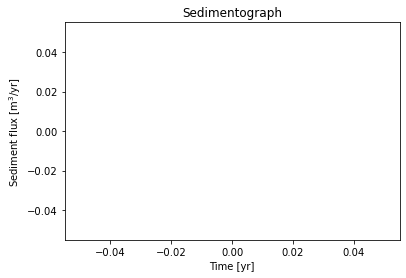

In [72]:
#Instantiate figure
fig = plt.figure()

#Instantiate subplot
sedfluxplot = plt.subplot()

#Plot data
sedfluxplot.plot(np.arange(run_time),sed_flux, color = 'k', linewidth = 3) ###Changed the arange(_) value from 500 to 400

#Add axis labels
sedfluxplot.set_title('Sedimentograph')
sedfluxplot.set_xlabel('Time [yr]')
sedfluxplot.set_ylabel(r'Sediment flux [m$^3$/yr]')